In [1]:
!pip -q install --upgrade pip
!pip -q install yfinance pandas_market_calendars --upgrade

🧠 Cell 2 — Imports & versions

In [2]:
import os, sys, platform, warnings, random, subprocess, textwrap, json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_market_calendars as mcal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, backend as K, regularizers

warnings.filterwarnings("ignore")

print("Python      :", sys.version.split()[0])
print("OS          :", platform.platform())
print("NumPy       :", np.__version__)
print("Pandas      :", pd.__version__)
print("Matplotlib  :", matplotlib.__version__)
print("scikit-learn:", __import__('sklearn').__version__)
print("TensorFlow  :", tf.__version__)
print("yfinance    :", yf.__version__)
print("pandas_market_calendars:", mcal.__version__)


Python      : 3.13.5
OS          : Windows-11-10.0.26100-SP0
NumPy       : 2.3.3
Pandas      : 2.3.2
Matplotlib  : 3.10.6
scikit-learn: 1.7.2
TensorFlow  : 2.20.0
yfinance    : 0.2.65
pandas_market_calendars: 5.1.1


🎲 Cell 3 — Reproducibility & runtime check

In [3]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("GPUs:", tf.config.list_physical_devices('GPU'))
try:
    out = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    print(textwrap.shorten(out.stdout, width=1000, placeholder="..."))
except Exception:
    print("nvidia-smi not available (CPU runtime is fine).")


GPUs: []
nvidia-smi not available (CPU runtime is fine).


⚙️ Cell 4 — Project config (AAPL Open, overnight return target)

In [4]:
# ===== PIPELINE: AAPL Open prediction via overnight log-return =====
# Target: r_overnight_t = ln(Open_t / Close_{t-1})
# Reconstruct: Ô_t = Close_{t-1} * exp(r̂_overnight_t)

# Core config
TICKER        = "AAPL"
START         = "2000-01-01"   # we'll trim to recent years
END           = None           # last completed UTC day
TRIM_YEARS    = 10             # keep recent years for stationarity
LOOKBACK      = 60             # 60–90 is typical
CALENDAR      = "XNYS"         # NYSE trading calendar
N_FUTURE_DEF  = 14             # default horizon for forecast UI later

# Guardrails
MIN_LOOKBACK      = 20
MAX_FUTURE_DAYS   = 252

# Artifact location for this OPEN model (we'll save later steps here)
OPEN_BASE_DIR = "models/base_aapl_open"
os.makedirs(OPEN_BASE_DIR, exist_ok=True)

# Meta (for display only)
print("✅ Config ready:")
print(f"  TICKER      : {TICKER}")
print(f"  START       : {START}")
print(f"  END         : {END}")
print(f"  LOOKBACK    : {LOOKBACK}")
print(f"  TRIM_YEARS  : {TRIM_YEARS}")
print(f"  CALENDAR    : {CALENDAR}")
print(f"  SAVE TO     : {OPEN_BASE_DIR}")
print("Target: overnight log-return  ln(Open_t / Close_{t-1})")


✅ Config ready:
  TICKER      : AAPL
  START       : 2000-01-01
  END         : None
  LOOKBACK    : 60
  TRIM_YEARS  : 10
  CALENDAR    : XNYS
  SAVE TO     : models/base_aapl_open
Target: overnight log-return  ln(Open_t / Close_{t-1})


# step 2

Cell 5 — Helpers (tz-safe dates, yf download, calendar align)

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_market_calendars as mcal
import time

def _last_completed_utc_day():
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize().tz_localize(None)

def _resolve_dates(start=None, end=None):
    s = pd.Timestamp(start) if start else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   else _last_completed_utc_day()
    return _utc_midnight_naive(s), _utc_midnight_naive(e)

def _flatten_columns(cols, ticker_expected=None):
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            sec = {t for (_, t) in cols}
            if len(sec) == 1 and (ticker_expected is None or list(sec)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlcv_yf(ticker, start_dt, end_dt, auto_adjust=True, max_retries=3, sleep_sec=1.5):
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    last_err = None
    for attempt in range(1, max_retries+1):
        try:
            df = yf.download(
                tickers=ticker, start=start_s, end=end_s,
                auto_adjust=auto_adjust, progress=False, threads=True, group_by="column"
            )
            if df is None or df.empty:
                raise ValueError(f"No data for {ticker} in {start_s}→{end_s}")
            # index & columns
            df.index = pd.to_datetime(df.index, utc=False)
            if getattr(df.index, "tz", None) is not None:
                df.index = df.index.tz_localize(None)
            df = df.sort_index().loc[~df.index.duplicated(keep="first")]
            df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())
            for c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            df = df.dropna(how="all")

            # align to trading calendar
            cal = mcal.get_calendar(CALENDAR)
            sched = cal.schedule(start_date=start_s, end_date=end_s)
            idx = sched.index
            if getattr(idx, "tz", None) is not None:
                idx = idx.tz_localize(None)
            idx = pd.DatetimeIndex(idx)
            df = df.loc[df.index.intersection(idx)]

            # Guards
            need = {"Open","Close"}
            if not need.issubset(set(df.columns)):
                raise ValueError(f"Missing columns {need - set(df.columns)}")
            df = df.dropna(subset=["Open","Close"])
            if not df.index.is_monotonic_increasing:
                df = df.sort_index()
            if df.empty:
                raise ValueError("All rows dropped after cleaning.")
            return df
        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(sleep_sec)
            else:
                raise RuntimeError(f"Fetch failed after {max_retries} attempts: {e}") from e


📈 Cell 6 — Download AAPL, trim, compute overnight log-returns

In [7]:
# Resolve window and fetch
START_DT, END_DT = _resolve_dates(START, END)
raw_df = fetch_ohlcv_yf(TICKER, START_DT, END_DT, auto_adjust=True)
print(f"✅ Downloaded {TICKER}: {len(raw_df)} rows | {raw_df.index.min().date()} → {raw_df.index.max().date()}")
print("Columns:", list(raw_df.columns))

# Keep only what we need
ohlc = raw_df[["Open","Close"]].copy()

# Trim to last TRIM_YEARS
cutoff = ohlc.index.max() - pd.DateOffset(years=TRIM_YEARS)
ohlc = ohlc[ohlc.index >= cutoff].copy()
print(f"Using last {TRIM_YEARS} years → {len(ohlc)} rows | {ohlc.index.min().date()} → {ohlc.index.max().date()}")

# Build overnight return series: r_ov_t = ln(Open_t / Close_{t-1})
prev_close = ohlc["Close"].shift(1)
overnight_logret = np.log(ohlc["Open"] / prev_close)
ovr_df = pd.DataFrame({
    "Open": ohlc["Open"],
    "Prev_Close": prev_close,
    "OvernightLogRet": overnight_logret
}).dropna()

# Guards
TOTAL_MIN_ROWS = LOOKBACK + 200
if len(ovr_df) < TOTAL_MIN_ROWS:
    raise ValueError(f"Not enough rows after trim/diff: have {len(ovr_df)}, need ≥ {TOTAL_MIN_ROWS}.")

assert isinstance(ovr_df.index, pd.DatetimeIndex) and ovr_df.index.tz is None
assert ovr_df.index.is_monotonic_increasing
assert np.isfinite(ovr_df["OvernightLogRet"]).all()

print("✅ Overnight return series ready:", ovr_df.shape)
print(ovr_df[["Prev_Close","Open","OvernightLogRet"]].tail(5))



✅ Downloaded AAPL: 6463 rows | 2000-01-03 → 2025-09-12
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Using last 10 years → 2515 rows | 2015-09-14 → 2025-09-12
✅ Overnight return series ready: (2514, 3)
            Prev_Close        Open  OvernightLogRet
2025-09-08  239.690002  239.300003        -0.001628
2025-09-09  237.880005  237.000000        -0.003706
2025-09-10  234.350006  232.190002        -0.009260
2025-09-11  226.789993  226.880005         0.000397
2025-09-12  230.029999  229.220001        -0.003527


 Cell 7 — Chronological split + StandardScaler (fit on train only)

In [8]:
from sklearn.preprocessing import StandardScaler

# 70 / 15 / 15 split (time-ordered)
n = len(ovr_df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = ovr_df.iloc[:train_end].copy()
val_df   = ovr_df.iloc[train_end:val_end].copy()
test_df  = ovr_df.iloc[val_end:].copy()

# Fit scaler ONLY on TRAIN (for OvernightLogRet)
scaler = StandardScaler()
scaler.fit(train_df[["OvernightLogRet"]])

def _scale(df: pd.DataFrame) -> pd.DataFrame:
    arr = scaler.transform(df[["OvernightLogRet"]])
    return pd.DataFrame(arr, index=df.index, columns=["OvernightLogRet"])

train_sc = _scale(train_df)
val_sc   = _scale(val_df)
test_sc  = _scale(test_df)

print(f"Rows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Train range:", train_df.index.min().date(), "→", train_df.index.max().date())
print("Val   range:", val_df.index.min().date(),   "→", val_df.index.max().date())
print("Test  range:", test_df.index.min().date(),  "→", test_df.index.max().date())

print("\nScaler (train only): mean, std =", float(scaler.mean_), float(scaler.scale_))
print("Train scaled mean/std ≈", float(train_sc.mean()), float(train_sc.std()))


Rows → Train: 1759 | Val: 377 | Test: 378
Train range: 2015-09-15 → 2022-09-08
Val   range: 2022-09-09 → 2024-03-11
Test  range: 2024-03-12 → 2025-09-12

Scaler (train only): mean, std = 0.00022765277231560007 0.012079492161497748
Train scaled mean/std ≈ -4.03946978828937e-18 1.000284373672747


🧩 Cell 8 — Build LSTM sequences (+ align Prev_Close for reconstruction)

In [9]:
import numpy as np

def create_sequences_std_overnight(
    data_scaled: pd.DataFrame,
    prev_close_series: pd.Series,
    lookback: int,
    col: str = "OvernightLogRet",
):
    """
    Build sequences from standardized overnight returns.
    For each target at time t, we also keep Prev_Close_t so we can reconstruct:
        Ô_t = Prev_Close_t * exp(r̂_overnight_t)
    """
    X, y, pc = [], [], []
    vals = data_scaled[col].values
    prev_vals = prev_close_series.reindex(data_scaled.index).values  # aligned to t

    for i in range(lookback, len(vals)):
        X.append(vals[i - lookback:i].reshape(lookback, 1))
        y.append(vals[i])
        pc.append(prev_vals[i])  # Prev_Close_t

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    pc = np.asarray(pc, dtype=np.float32)

    return X, y, pc

# Sequences for each split
X_train, y_train, pc_train = create_sequences_std_overnight(
    train_sc, train_df["Prev_Close"], LOOKBACK
)
X_val,   y_val,   pc_val   = create_sequences_std_overnight(
    val_sc,   val_df["Prev_Close"],   LOOKBACK
)
X_test,  y_test,  pc_test  = create_sequences_std_overnight(
    test_sc,  test_df["Prev_Close"],  LOOKBACK
)

print("✅ Sequences built.")
print("  Train:", X_train.shape, y_train.shape, pc_train.shape)
print("  Val  :", X_val.shape,   y_val.shape,   pc_val.shape)
print("  Test :", X_test.shape,  y_test.shape,  pc_test.shape)

# Guards
assert X_train.shape[-1] == 1, "Univariate sequences must have 1 feature."
assert not np.isnan(X_train).any() and not np.isnan(y_train).any(), "NaNs in training sequences."
assert np.all(pc_train > 0), "Prev_Close must be positive for reconstruction."


✅ Sequences built.
  Train: (1699, 60, 1) (1699,) (1699,)
  Val  : (317, 60, 1) (317,) (317,)
  Test : (318, 60, 1) (318,) (318,)


🧱 Cell 9 — Build & compile the LSTM (overnight returns)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, regularizers, backend as K
import tensorflow as tf

# Safety: confirm shapes from Step 3
assert X_train.ndim == 3 and X_train.shape[1] == LOOKBACK, "X_train shape mismatch."
N_FEATURES = X_train.shape[2]
print(f"LOOKBACK={LOOKBACK}, N_FEATURES={N_FEATURES} (should be 1)")

# R² metric (on standardized returns; final eval will be on price scale)
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())

def make_lstm_overnight_model(
    lookback: int = LOOKBACK,
    n_features: int = N_FEATURES,
    lr: float = 2e-4,
    use_conv_denoiser: bool = True,
    bidirectional: bool = True,
):
    K.clear_session()

    inp = keras.Input(shape=(lookback, n_features), name="seq")

    x = inp
    if use_conv_denoiser:
        # tiny denoiser on standardized overnight returns
        x = layers.Conv1D(
            filters=16, kernel_size=3, padding="same",
            activation="swish", kernel_regularizer=regularizers.l2(1e-6)
        )(x)
        x = layers.Dropout(0.10)(x)

    # recurrent stack
    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True,
                                             kernel_regularizer=regularizers.l2(1e-6)))(x)
    else:
        x = layers.LSTM(64, return_sequences=True,
                        kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.20)(x)
    x = layers.LayerNormalization()(x)

    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(32, return_sequences=False,
                                             kernel_regularizer=regularizers.l2(1e-6)))(x)
    else:
        x = layers.LSTM(32, return_sequences=False,
                        kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.15)(x)

    # dense head
    x = layers.Dense(64, activation="swish")(x)
    x = layers.Dropout(0.10)(x)
    out = layers.Dense(1, name="overnight_logret_std")(x)  # standardized r_overnight_t

    model = keras.Model(inp, out, name="lstm_overnight_open")

    # robust loss for fat-tailed returns
    loss = keras.losses.Huber(delta=1.0)
    opt  = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse"), r2_metric],
    )
    return model

model = make_lstm_overnight_model()
model.summary()


LOOKBACK=60, N_FEATURES=1 (should be 1)



Model: "lstm_overnight_open"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq (InputLayer)                │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ overnight_logret_std (Dense)    │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 87,233 (340.75 KB)

 Non-trainable params: 0 (0.00 B)

 Cell 10 — Sanity forward pass

In [11]:
# Quick prediction to verify graph & shapes (no training yet)
y_pred_sample = model.predict(X_train[:2], verbose=0)
print("Pred shape:", y_pred_sample.shape)  # (2, 1) expected
print("✅ Model graph OK. Trainable params:", model.count_params())


Pred shape: (2, 1)
✅ Model graph OK. Trainable params: 87233


🏃 Cell 11 — Train (callbacks but no saving)

In [12]:
# TRAIN ONLY: no checkpoints/saving here
EPOCHS     = 120
BATCH_SIZE = 64

cb = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=18, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=8, min_delta=1e-4, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.TerminateOnNaN()
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    verbose=1
)

print("✅ Training complete (no files saved). Best val_loss:",
      np.min(history.history["val_loss"]))


Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 122ms/step - loss: 0.3197 - mean_absolute_error: 0.6176 - r2_metric: -65.1336 - rmse: 1.0203 - val_loss: 0.1912 - val_mean_absolute_error: 0.4686 - val_r2_metric: -63.9883 - val_rmse: 0.6817 - learning_rate: 2.0000e-04
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.3161 - mean_absolute_error: 0.6159 - r2_metric: -64.6714 - rmse: 1.0179 - val_loss: 0.1921 - val_mean_absolute_error: 0.4683 - val_r2_metric: -64.2525 - val_rmse: 0.6831 - learning_rate: 2.0000e-04
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.3125 - mean_absolute_error: 0.6097 - r2_metric: -64.4375 - rmse: 1.0102 - val_loss: 0.1915 - val_mean_absolute_error: 0.4678 - val_r2_metric: -64.1191 - val_rmse: 0.6818 - learning_rate: 2.0000e-04
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.3135 - mean_absolute_error: 0.6121 - r2_metric: -64.2967 - rmse: 1.0126 - val_loss: 0.1913 - val_mean_absolute_error: 0.4667 - val_r2_metric: -63.9553 - val

✅ Cell 12 — Validation metrics (price & gap) + preview

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Predict standardized overnight returns on the validation sequences
y_pred_std = model.predict(X_val, verbose=0).ravel()
y_true_std = y_val.ravel()

# 2) Inverse-transform to actual overnight log-returns
y_pred_log = scaler.inverse_transform(y_pred_std.reshape(-1, 1)).ravel()
y_true_log = scaler.inverse_transform(y_true_std.reshape(-1, 1)).ravel()

# 3) Reconstruct next-day OPEN using Prev_Close_t
pred_open = pc_val * np.exp(y_pred_log)
true_open = pc_val * np.exp(y_true_log)

# 4) Also compute "gap" (open minus previous close) for direction & error
pred_gap = pred_open - pc_val
true_gap = true_open - pc_val

# 5) Metrics — price scale
mae_price  = mean_absolute_error(true_open, pred_open)
rmse_price = np.sqrt(mean_squared_error(true_open, pred_open))
mape_price = (np.abs((true_open - pred_open) / np.maximum(1e-8, np.abs(true_open)))).mean() * 100.0
r2_price   = r2_score(true_open, pred_open)

# 6) Metrics — gap (optional but informative)
mae_gap  = mean_absolute_error(true_gap, pred_gap)
rmse_gap = np.sqrt(mean_squared_error(true_gap, pred_gap))
r2_gap   = r2_score(true_gap, pred_gap)

# 7) Directional accuracy: did we get the sign of the overnight gap right?
da_gap = (np.sign(pred_gap) == np.sign(true_gap)).mean() * 100.0

print("📊 Validation — Next-day OPEN (price scale)")
print(f"  MAE (price):   {mae_price:.4f}")
print(f"  RMSE (price):  {rmse_price:.4f}")
print(f"  MAPE (price):  {mape_price:.2f}%")
print(f"  R² Accuracy percentage (price):    {r2_price*100:.4f}%")
print("\n📊 Validation — Overnight Gap (Open - PrevClose)")
print(f"  MAE (gap):     {mae_gap:.4f}")
print(f"  RMSE (gap):    {rmse_gap:.4f}")
print(f"  R² (gap):      {r2_gap:.4f}")
print(f"  Directional Accuracy (gap sign): {da_gap:.2f}%")

# 8) Preview the last few validation samples
val_dates = val_df.index[LOOKBACK:]
preview = pd.DataFrame({
    "prev_close": pc_val[-5:],
    "true_open":  true_open[-5:],
    "pred_open":  pred_open[-5:],
    "true_gap":   true_gap[-5:],
    "pred_gap":   pred_gap[-5:]
}, index=pd.Index(val_dates[-5:], name="date")).round(4)
display(preview)

📊 Validation — Next-day OPEN (price scale)
  MAE (price):   0.9445
  RMSE (price):  1.3844
  MAPE (price):  0.56%
  R² Accuracy percentage (price):    99.4443%

📊 Validation — Overnight Gap (Open - PrevClose)
  MAE (gap):     0.9445
  RMSE (gap):    1.3844
  R² (gap):      -0.0043
  Directional Accuracy (gap sign): 54.26%


,prev_close,true_open,pred_open,true_gap,pred_gap
date,,,,,
2024-03-05,173.851593,169.542496,173.954498,-4.3091,0.1029
2024-03-06,168.906998,169.840393,169.079193,0.9333,0.1722
2024-03-07,167.914200,167.944000,167.960403,0.0298,0.0462
2024-03-08,167.794998,167.794998,167.795700,-0.0000,0.0007
2024-03-11,169.512695,171.707001,169.499496,2.1943,-0.0132


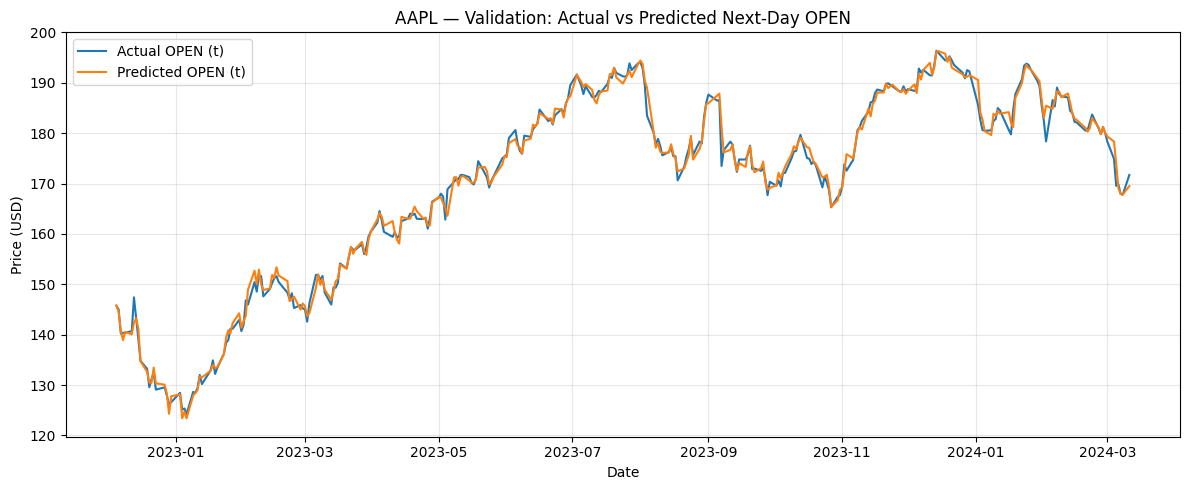

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(val_dates, true_open, label="Actual OPEN (t)")
plt.plot(val_dates, pred_open, label="Predicted OPEN (t)")
plt.title(f"{TICKER} — Validation: Actual vs Predicted Next-Day OPEN")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()




💾 Cell 14 — Save the AAPL-Open bundle (model + scaler + config)

In [17]:
import os, json, joblib
from tensorflow import keras

# Make sure the directory from Cell 4 exists
os.makedirs(OPEN_BASE_DIR, exist_ok=True)

# 1) Save model (native Keras format)
open_model_path = os.path.join(OPEN_BASE_DIR, "model.keras")
model.save(open_model_path)

# 2) Save scaler (fit on TRAIN OvernightLogRet)
open_scaler_path = os.path.join(OPEN_BASE_DIR, "scaler.pkl")
joblib.dump(scaler, open_scaler_path)

# 3) Save config (for provenance)
open_cfg = {
    "pipeline": "univariate_overnight_open",
    "ticker": "AAPL",
    "lookback": LOOKBACK,
    "trim_years": TRIM_YEARS,
    "calendar": CALENDAR,
    "feature_in": "OvernightLogRet (standardized)",
    "target": "OvernightLogRet",
    "reconstruction": "Open_t = Prev_Close_t * exp(OvernightLogRet_t)",
}
open_cfg_path = os.path.join(OPEN_BASE_DIR, "config.json")
with open(open_cfg_path, "w") as f:
    json.dump(open_cfg, f, indent=2)

print("✅ Saved AAPL-Open base bundle:")
print("  model :", open_model_path)
print("  scaler:", open_scaler_path)
print("  config:", open_cfg_path)


✅ Saved AAPL-Open base bundle:
  model : models/base_aapl_open\model.keras
  scaler: models/base_aapl_open\scaler.pkl
  config: models/base_aapl_open\config.json


🔎 Cell 15 — Quick integrity check (reload & dry-run)

In [18]:
from tensorflow import keras
import numpy as np
import joblib, os

assert os.path.exists(open_model_path) and os.path.exists(open_scaler_path) and os.path.exists(open_cfg_path), \
    "Export files missing."

m_chk = keras.models.load_model(open_model_path, compile=False)
s_chk = joblib.load(open_scaler_path)

# Dry-run a tiny forward pass on validation (no training)
y_hat_std = m_chk.predict(X_val[:2], verbose=0).ravel()
y_hat_log = s_chk.inverse_transform(y_hat_std.reshape(-1,1)).ravel()
o_hat     = pc_val[:2] * np.exp(y_hat_log)

print("Model layers :", len(m_chk.layers))
print("Sample preds :", o_hat)
print("✅ Reload OK — bundle is ready to use.")


Model layers : 11
Sample preds : [145.80014 144.57246]
✅ Reload OK — bundle is ready to use.


🔢 Cell 16 — Ask user for N and (optionally) load the Close base to build a prev-close path

In [22]:
import os, json, joblib
from tensorflow import keras

# ---- Ask N ----
try:
    rawN = input(f"Enter FUTURE trading days to forecast for {TICKER} (1–{MAX_FUTURE_DAYS}) [Enter={N_FUTURE_DEF}]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = int(N_FUTURE_DEF)
else:
    try:
        n = int(rawN)
        if not (1 <= n <= MAX_FUTURE_DAYS):
            raise ValueError
        N_FUTURE = n
    except Exception:
        print(f"⚠️ Invalid input. Falling back to default {N_FUTURE_DEF}.")
        N_FUTURE = int(N_FUTURE_DEF)

print(f"✅ Forecast horizon (OPEN): {N_FUTURE} trading days")

# ---- Try to load the CLOSE base bundle to get a prev-close path ----
CLOSE_BASE_DIR = "models/base_aapl"   # your Close model bundle from earlier steps

def _load_close_bundle():
    """Load AAPL Close model + scaler + config if present; return (model, scaler, cfg) or (None, None, None)."""
    mpath = os.path.join(CLOSE_BASE_DIR, "model.keras")
    spath = os.path.join(CLOSE_BASE_DIR, "scaler.pkl")
    cpath = os.path.join(CLOSE_BASE_DIR, "config.json")
    if not (os.path.exists(mpath) and os.path.exists(spath)):
        return None, None, None
    cfg = None
    if os.path.exists(cpath):
        with open(cpath, "r") as f:
            cfg = json.load(f)
    try:
        m = keras.models.load_model(mpath, custom_objects={"r2_metric": r2_metric})
        s = joblib.load(spath)
        return m, s, cfg
    except Exception as e:
        print("⚠️ Could not load Close base bundle:", e)
        return None, None, None

close_model, close_scaler, close_cfg = _load_close_bundle()
if close_model is None:
    print("ℹ️ Close base model not found — will fallback to using predicted OPEN as proxy for next prev-close.")
else:
    print("✅ Loaded Close base bundle for prev-close path.")
    # Ensure lookback compatibility
    CLOSE_LOOKBACK = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if CLOSE_LOOKBACK != LOOKBACK:
        print(f"ℹ️ Close LOOKBACK={CLOSE_LOOKBACK} differs from OPEN LOOKBACK={LOOKBACK}. We'll still proceed.")

# Helper: build prev-close path using Close base model if available
def build_prev_close_path_via_close_model(n_steps: int):
    """Build a realistic prev-close path using the Close base model if available.
       Uses `ohlc['Close']` from earlier cells. Returns np.ndarray or None."""
    if close_model is None or close_scaler is None:
        return None

    # 1) Daily log-returns for Close (from our trimmed series)
    close_series = ohlc["Close"].copy()
    ret_close = pd.DataFrame({"LogRet": np.log(close_series).diff()}).dropna()

    # 2) Standardize with base Close scaler
    std_close = pd.DataFrame(
        close_scaler.transform(ret_close[["LogRet"]]),
        index=ret_close.index, columns=["LogRet"]
    )

    # 3) Seed window
    L = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if len(std_close) < L:
        return None
    window = std_close.values[-L:].astype(np.float32).reshape(L, 1)

    # 4) Recursive next-close forecast
    last_close = float(close_series.iloc[-1])
    preds_close = []
    cur = window.copy()
    prev = last_close
    for _ in range(n_steps):
        y_std = float(close_model.predict(cur.reshape(1, L, 1), verbose=0).ravel()[0])
        y_log = float(close_scaler.inverse_transform([[y_std]])[0, 0])
        next_close = prev * np.exp(y_log)
        preds_close.append(next_close)
        cur = np.vstack([cur[1:], [[y_std]]])
        prev = next_close

    # 5) Prev-close used for OPEN step k:
    prev_closes = np.empty(n_steps, dtype=np.float32)
    prev_closes[0] = last_close
    if n_steps > 1:
        prev_closes[1:] = np.asarray(preds_close[:-1], dtype=np.float32)
    return prev_closes

# Call (no param now)
prev_close_path = build_prev_close_path_via_close_model(N_FUTURE)
if prev_close_path is not None:
    print("✅ Prev-close path obtained from Close model.")
else:
    print("⚠️ Using fallback prev-close path (prev_close[t] = predicted OPEN[t-1]).")


✅ Forecast horizon (OPEN): 30 trading days
✅ Loaded Close base bundle for prev-close path.
ℹ️ Close LOOKBACK=90 differs from OPEN LOOKBACK=60. We'll still proceed.
✅ Loaded Close base bundle for prev-close path.
ℹ️ Close LOOKBACK=90 differs from OPEN LOOKBACK=60. We'll still proceed.
✅ Prev-close path obtained from Close model.
✅ Prev-close path obtained from Close model.


In [23]:
import os, json, joblib
from tensorflow import keras

# ---- Ask N ----
try:
    rawN = input(f"Enter FUTURE trading days to forecast for {TICKER} (1–{MAX_FUTURE_DAYS}) [Enter={N_FUTURE_DEF}]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = int(N_FUTURE_DEF)
else:
    try:
        n = int(rawN)
        if not (1 <= n <= MAX_FUTURE_DAYS):
            raise ValueError
        N_FUTURE = n
    except Exception:
        print(f"⚠️ Invalid input. Falling back to default {N_FUTURE_DEF}.")
        N_FUTURE = int(N_FUTURE_DEF)

print(f"✅ Forecast horizon (OPEN): {N_FUTURE} trading days")

# ---- Try to load the CLOSE base bundle to get a prev-close path ----
CLOSE_BASE_DIR = "models/base_aapl"   # your Close model bundle from earlier steps

def _load_close_bundle():
    """Load AAPL Close model + scaler + config if present; return (model, scaler, cfg) or (None, None, None)."""
    mpath = os.path.join(CLOSE_BASE_DIR, "model.keras")
    spath = os.path.join(CLOSE_BASE_DIR, "scaler.pkl")
    cpath = os.path.join(CLOSE_BASE_DIR, "config.json")
    if not (os.path.exists(mpath) and os.path.exists(spath)):
        return None, None, None
    cfg = None
    if os.path.exists(cpath):
        with open(cpath, "r") as f:
            cfg = json.load(f)
    try:
        m = keras.models.load_model(mpath, custom_objects={"r2_metric": r2_metric})
        s = joblib.load(spath)
        return m, s, cfg
    except Exception as e:
        print("⚠️ Could not load Close base bundle:", e)
        return None, None, None

close_model, close_scaler, close_cfg = _load_close_bundle()
if close_model is None:
    print("ℹ️ Close base model not found — will fallback to using predicted OPEN as proxy for next prev-close.")
else:
    print("✅ Loaded Close base bundle for prev-close path.")
    # Ensure lookback compatibility
    CLOSE_LOOKBACK = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if CLOSE_LOOKBACK != LOOKBACK:
        print(f"ℹ️ Close LOOKBACK={CLOSE_LOOKBACK} differs from OPEN LOOKBACK={LOOKBACK}. We'll still proceed.")

# Helper: build prev-close path using Close base model if available
def build_prev_close_path_via_close_model(n_steps: int):
    """Build a realistic prev-close path using the Close base model if available.
       Uses `ohlc['Close']` from earlier cells. Returns np.ndarray or None."""
    if close_model is None or close_scaler is None:
        return None

    # 1) Daily log-returns for Close (from our trimmed series)
    close_series = ohlc["Close"].copy()
    ret_close = pd.DataFrame({"LogRet": np.log(close_series).diff()}).dropna()

    # 2) Standardize with base Close scaler
    std_close = pd.DataFrame(
        close_scaler.transform(ret_close[["LogRet"]]),
        index=ret_close.index, columns=["LogRet"]
    )

    # 3) Seed window
    L = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if len(std_close) < L:
        return None
    window = std_close.values[-L:].astype(np.float32).reshape(L, 1)

    # 4) Recursive next-close forecast
    last_close = float(close_series.iloc[-1])
    preds_close = []
    cur = window.copy()
    prev = last_close
    for _ in range(n_steps):
        y_std = float(close_model.predict(cur.reshape(1, L, 1), verbose=0).ravel()[0])
        y_log = float(close_scaler.inverse_transform([[y_std]])[0, 0])
        next_close = prev * np.exp(y_log)
        preds_close.append(next_close)
        cur = np.vstack([cur[1:], [[y_std]]])
        prev = next_close

    # 5) Prev-close used for OPEN step k:
    prev_closes = np.empty(n_steps, dtype=np.float32)
    prev_closes[0] = last_close
    if n_steps > 1:
        prev_closes[1:] = np.asarray(preds_close[:-1], dtype=np.float32)
    return prev_closes

# Call (no param now)
prev_close_path = build_prev_close_path_via_close_model(N_FUTURE)
if prev_close_path is not None:
    print("✅ Prev-close path obtained from Close model.")
else:
    print("⚠️ Using fallback prev-close path (prev_close[t] = predicted OPEN[t-1]).")


✅ Forecast horizon (OPEN): 30 trading days
✅ Loaded Close base bundle for prev-close path.
ℹ️ Close LOOKBACK=90 differs from OPEN LOOKBACK=60. We'll still proceed.
✅ Prev-close path obtained from Close model.


✅ OPEN forecast ready:


,prev_close_used,pred_overnight_logret,pred_open
date,,,
2025-09-15,234.070007,0.002074,234.556048
2025-09-16,233.157654,0.001817,233.581743
2025-09-17,231.853394,0.001088,232.105814
2025-09-18,231.429062,0.000827,231.620600
2025-09-19,231.482651,0.000399,231.574932


,prev_close_used,pred_overnight_logret,pred_open
date,,,
2025-10-20,219.299576,0.000514,219.412287
2025-10-21,220.287796,0.000529,220.404463
2025-10-22,220.967789,0.000681,221.118407
2025-10-23,221.508743,0.000860,221.699398
2025-10-24,221.805679,0.001126,222.055510


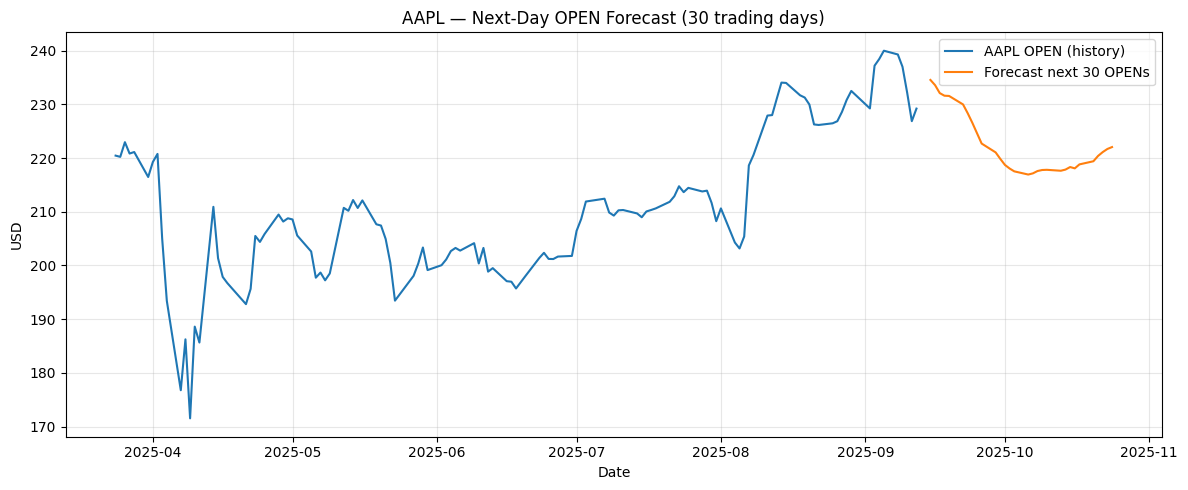

In [24]:
# Seed window for OPEN = last LOOKBACK standardized OvernightLogRet values
combined_std_open = pd.concat([train_sc["OvernightLogRet"], val_sc["OvernightLogRet"], test_sc["OvernightLogRet"]]).sort_index()
assert len(combined_std_open) >= LOOKBACK, "Not enough history to seed window."
seed_window_open = combined_std_open.values[-LOOKBACK:].astype(np.float32).reshape(LOOKBACK, 1)

# Prepare iteration
last_actual_close = float(ovr_df["Prev_Close"].iloc[-1])  # same as last known Close
pred_overnight_std = []
pred_overnight_log = []
pred_open_series   = []
used_prev_close    = []

cur_win = seed_window_open.copy()

# Calendar future dates
def future_trading_days(last_date: pd.Timestamp, n: int) -> pd.DatetimeIndex:
    cal = mcal.get_calendar(CALENDAR)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)[:n]
    if len(idx) < n: raise ValueError("Not enough future trading days.")
    return idx

future_idx = future_trading_days(ovr_df.index.max(), N_FUTURE)

# Iterate
prev_for_step = last_actual_close
for k in range(N_FUTURE):
    # if we have a Close path, use it; else use last predicted OPEN as proxy
    if prev_close_path is not None:
        prev_for_step = float(prev_close_path[k])

    y_std = float(model.predict(cur_win.reshape(1, LOOKBACK, 1), verbose=0).ravel()[0])
    y_log = float(scaler.inverse_transform([[y_std]])[0, 0])
    o_hat = prev_for_step * np.exp(y_log)

    pred_overnight_std.append(y_std)
    pred_overnight_log.append(y_log)
    pred_open_series.append(o_hat)
    used_prev_close.append(prev_for_step)

    # slide OPEN seed window with predicted standardized overnight return
    cur_win = np.vstack([cur_win[1:], [[y_std]]])

    # fallback path needs to advance prev close
    if prev_close_path is None:
        prev_for_step = o_hat  # proxy: assume close ≈ open (fallback only)

# Assemble forecast DataFrame
forecast_open_df = pd.DataFrame({
    "prev_close_used": used_prev_close,
    "pred_overnight_logret": pred_overnight_log,
    "pred_open": pred_open_series,
}, index=future_idx)
forecast_open_df.index.name = "date"

print("✅ OPEN forecast ready:")
display(forecast_open_df.head()); display(forecast_open_df.tail())

# Plot last history + forecast
hist_days = 120
hist_open = ovr_df.tail(hist_days).copy()  # has Open and Prev_Close columns
plt.figure(figsize=(12,5))
plt.plot(hist_open.index, hist_open["Open"], label=f"{TICKER} OPEN (history)")
plt.plot(forecast_open_df.index, forecast_open_df["pred_open"], label=f"Forecast next {N_FUTURE} OPENs")
plt.title(f"{TICKER} — Next-Day OPEN Forecast ({N_FUTURE} trading days)")
plt.xlabel("Date"); plt.ylabel("USD")
plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
